# <center> Navie Bayes Model

## Load Pacakage.

In [37]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
import plotly.express as px
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

## Load data

In [38]:
file=os.path.dirname(os.getcwd())
Clean_DF = pd.read_csv(file+'\\data\\Steam_Clean_Data.csv')
Train_reco = pd.read_csv(file+'\\data\\Train_reco.csv')
Test_reco = pd.read_csv(file+'\\data\\Test_reco.csv')

## Transform Recomendation Data.

Use tfidvectorizer to transform text data

In [39]:
Tfidf_reco=TfidfVectorizer(
    input="content",
    lowercase=True, 
    stop_words = "english",max_features = 1000)
Train_DTM_reco = Tfidf_reco.fit_transform(Train_reco['review'])
Test_DTM_reco = Tfidf_reco.transform(Test_reco['review'])
DTM_reco=Tfidf_reco.fit_transform(Clean_DF['review'])

Convert tfidvectorizer result to pandas data frame.

In [40]:
Train_DTM_DF_reco=pd.DataFrame(Train_DTM_reco.toarray(),columns=Tfidf_reco.get_feature_names())
Test_DTM_DF_reco=pd.DataFrame(Test_DTM_reco.toarray(),columns=Tfidf_reco.get_feature_names())
DTM_DF_reco=pd.DataFrame(DTM_reco.toarray(),columns=Tfidf_reco.get_feature_names())

## Recommendation Model

Set an instantiate logistic model

In [41]:
## Instantiate
nb_reco=MultinomialNB()


Use trran data to fit the model.

In [42]:
nb_reco.fit(Train_DTM_DF_reco, Train_reco['recommendation'])

MultinomialNB()

Predict the test data

In [43]:
nb_pred_reco=nb_reco.predict(Test_DTM_DF_reco)

Create a confusion matrix


The confusion matrix is:
[[16097 11524]
 [ 3791 52404]]


0.817278323947695

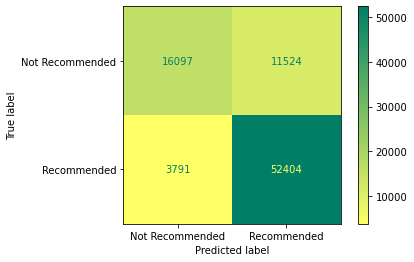

In [44]:
bn_matrix = confusion_matrix(Test_reco['recommendation'], nb_pred_reco)
print("\nThe confusion matrix is:")
print(bn_matrix)
plot_confusion_matrix(nb_reco, Test_DTM_DF_reco, Test_reco['recommendation'], cmap = 'summer_r')
#plt.savefig('MyTree1_cm.png')
accuracy_score(Test_reco['recommendation'], nb_pred_reco)

Use cross valiadation to generate logistic model.

In [49]:
cv_reco=cross_validate(MultinomialNB(), DTM_DF_reco, Clean_DF['recommendation'], cv=6, scoring = 'accuracy', return_estimator =True)


In [50]:
cv_reco['test_score'].mean()

0.793866331198729

## Feature Importance

Features sorted by their score for estimator 0:
Features sorted by their score for estimator 1:
Features sorted by their score for estimator 2:
Features sorted by their score for estimator 3:
Features sorted by their score for estimator 4:
Features sorted by their score for estimator 5:


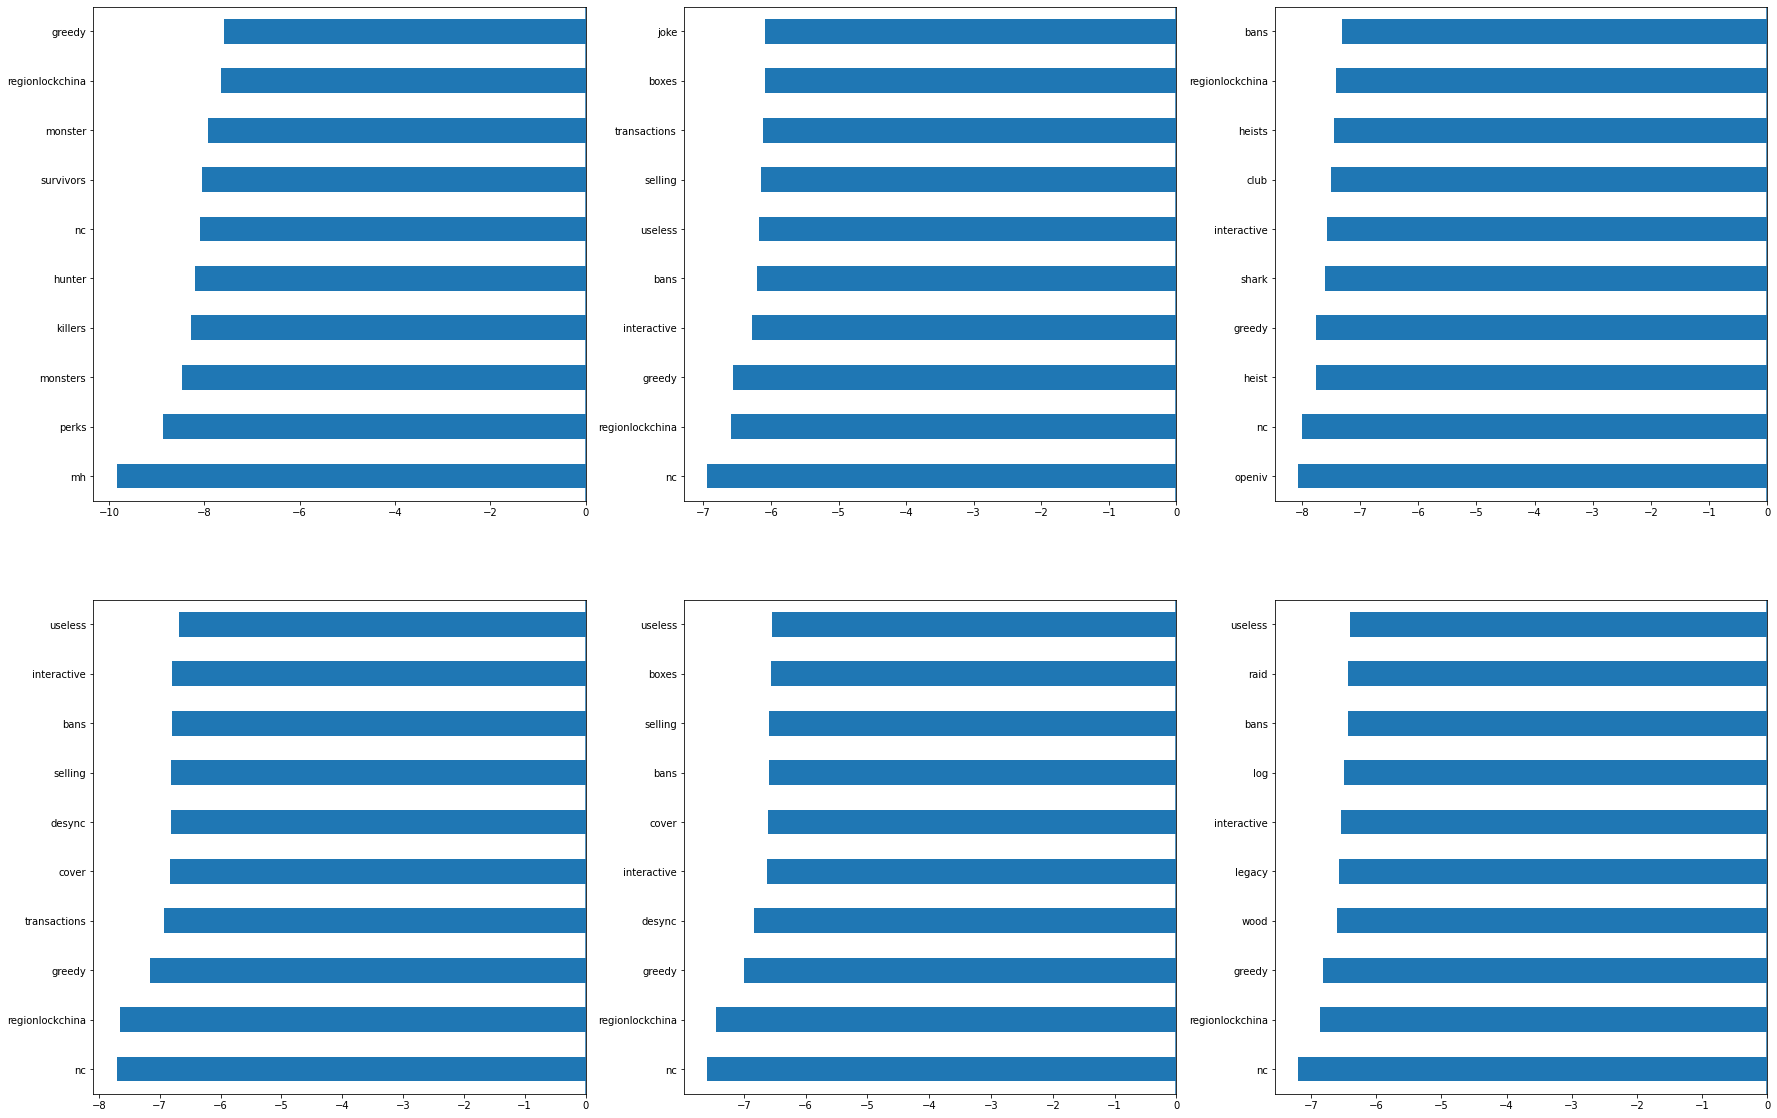

In [56]:
fig=plt.figure(figsize=(30,20))
for idx,estimator in enumerate(cv_reco['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.coef_.T,
                                       index = DTM_DF_reco.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    feature_importances=feature_importances['importance']*np.var(feature_importances['importance'])
    feature_importances=feature_importances.sort_values(key=abs,ascending=False)
    feature_importances=feature_importances.head(10)
    plt.subplot(231+idx)
    feature_importances.plot.barh()
    plt.axis("on")
    plt.axvline(0, linestyle='-')